In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from openbb import obb
obb.user.preferences.output_type = "dataframe"

# Assess cyclicality of stock market returns based on monthly options expiration

## Get daily price data

In [2]:
# Date range carefully chosen so that both the first
# and last days are options expiration days
spy = obb.equity.price.historical(
    "SPY", 
    start_date="2011-12-16", 
    end_date="2024-09-20", 
    provider="yfinance"
)

In [3]:
spy

,open,high,low,close,volume,split_ratio,dividend,capital_gains
date,,,,,,,,
2011-12-16,122.230003,122.949997,121.300003,121.589996,220481400,0.0,0.770,0.0
2011-12-19,122.059998,122.320000,120.029999,120.290001,183903000,0.0,0.000,0.0
2011-12-20,122.180000,124.139999,120.370003,123.930000,225418100,0.0,0.000,0.0
2011-12-21,123.930000,124.360001,122.750000,124.169998,194230900,0.0,0.000,0.0
2011-12-22,124.629997,125.400002,124.230003,125.269997,119465400,0.0,0.000,0.0
...,...,...,...,...,...,...,...,...
2024-09-16,561.739990,563.109985,559.900024,562.840027,36656100,0.0,0.000,0.0
2024-09-17,565.099976,566.580017,560.789978,563.070007,49321000,0.0,0.000,0.0
2024-09-18,563.739990,568.690002,560.830017,561.400024,59044900,0.0,0.000,0.0


### Add calculated series: 1-day log return and day of week

In [4]:
spy.index = pd.to_datetime(spy.index).tz_localize("US/Eastern")

In [5]:
# compute log returns
spy["log_return"] = spy['close'].apply(np.log).diff(1)
# add a column with the day of the week
spy["day_of_week"] = spy.index.dayofweek

### Identify options expiration days

In [6]:
spy['opex_day'] = (spy.index.dayofweek == 4) & (spy.index.day >= 15) & (spy.index.day <= 21)

In [7]:
# In years in which Good Friday was the 3rd Friday
# (and hence the market was closed), designate the day before
# Good Friday as opex_day.
spy.at['2014-04-17', 'opex_day'] = True
spy.at['2019-04-18', 'opex_day'] = True
spy.at['2022-04-14', 'opex_day'] = True

### Identify the number of trading days before and after options expiration

In [8]:
spy['days_after_opex'] = spy.groupby(spy['opex_day'].eq(True).cumsum()).cumcount()

In [9]:
desc = spy.sort_index(ascending=False)

In [10]:
desc['days_before_opex'] = desc.groupby(desc['opex_day'].eq(True).cumsum()).cumcount()

In [11]:
desc

,open,high,low,close,volume,split_ratio,dividend,capital_gains,log_return,day_of_week,opex_day,days_after_opex,days_before_opex
date,,,,,,,,,,,,,
2024-09-20 00:00:00-04:00,567.840027,569.309998,565.169983,568.250000,77503100,0.0,1.746,0.0,-0.004793,4,True,0,0
2024-09-19 00:00:00-04:00,571.010010,572.880005,568.080017,570.979980,75315500,0.0,0.000,0.0,0.016920,3,False,23,1
2024-09-18 00:00:00-04:00,563.739990,568.690002,560.830017,561.400024,59044900,0.0,0.000,0.0,-0.002970,2,False,22,2
2024-09-17 00:00:00-04:00,565.099976,566.580017,560.789978,563.070007,49321000,0.0,0.000,0.0,0.000409,1,False,21,3
2024-09-16 00:00:00-04:00,561.739990,563.109985,559.900024,562.840027,36656100,0.0,0.000,0.0,0.001476,0,False,20,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-22 00:00:00-05:00,124.629997,125.400002,124.230003,125.269997,119465400,0.0,0.000,0.0,0.008820,3,False,4,18
2011-12-21 00:00:00-05:00,123.930000,124.360001,122.750000,124.169998,194230900,0.0,0.000,0.0,0.001935,2,False,3,19
2011-12-20 00:00:00-05:00,122.180000,124.139999,120.370003,123.930000,225418100,0.0,0.000,0.0,0.029811,1,False,2,20


In [12]:
spy['days_before_opex'] = desc['days_before_opex']

In [13]:
spy['before_or_after'] = np.where(
    (spy['days_before_opex'] < spy['days_after_opex']),
    - spy['days_before_opex'], spy['days_after_opex'])

In [14]:
spy

,open,high,low,close,volume,split_ratio,dividend,capital_gains,log_return,day_of_week,opex_day,days_after_opex,days_before_opex,before_or_after
date,,,,,,,,,,,,,,
2011-12-16 00:00:00-05:00,122.230003,122.949997,121.300003,121.589996,220481400,0.0,0.770,0.0,NaN,4,True,0,0,0
2011-12-19 00:00:00-05:00,122.059998,122.320000,120.029999,120.290001,183903000,0.0,0.000,0.0,-0.010749,0,False,1,21,1
2011-12-20 00:00:00-05:00,122.180000,124.139999,120.370003,123.930000,225418100,0.0,0.000,0.0,0.029811,1,False,2,20,2
2011-12-21 00:00:00-05:00,123.930000,124.360001,122.750000,124.169998,194230900,0.0,0.000,0.0,0.001935,2,False,3,19,3
2011-12-22 00:00:00-05:00,124.629997,125.400002,124.230003,125.269997,119465400,0.0,0.000,0.0,0.008820,3,False,4,18,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-16 00:00:00-04:00,561.739990,563.109985,559.900024,562.840027,36656100,0.0,0.000,0.0,0.001476,0,False,20,4,-4
2024-09-17 00:00:00-04:00,565.099976,566.580017,560.789978,563.070007,49321000,0.0,0.000,0.0,0.000409,1,False,21,3,-3
2024-09-18 00:00:00-04:00,563.739990,568.690002,560.830017,561.400024,59044900,0.0,0.000,0.0,-0.002970,2,False,22,2,-2


In [15]:
spy['pop_avg_return'] = spy['log_return'].mean()
spy['relative_return'] = spy['log_return'] - spy['pop_avg_return']

In [16]:
spy[0:5]

,open,high,low,close,volume,split_ratio,dividend,capital_gains,log_return,day_of_week,opex_day,days_after_opex,days_before_opex,before_or_after,pop_avg_return,relative_return
date,,,,,,,,,,,,,,,,
2011-12-16 00:00:00-05:00,122.230003,122.949997,121.300003,121.589996,220481400,0.0,0.77,0.0,NaN,4,True,0,0,0,0.00048,NaN
2011-12-19 00:00:00-05:00,122.059998,122.320000,120.029999,120.290001,183903000,0.0,0.00,0.0,-0.010749,0,False,1,21,1,0.00048,-0.011230
2011-12-20 00:00:00-05:00,122.180000,124.139999,120.370003,123.930000,225418100,0.0,0.00,0.0,0.029811,1,False,2,20,2,0.00048,0.029331
2011-12-21 00:00:00-05:00,123.930000,124.360001,122.750000,124.169998,194230900,0.0,0.00,0.0,0.001935,2,False,3,19,3,0.00048,0.001454
2011-12-22 00:00:00-05:00,124.629997,125.400002,124.230003,125.269997,119465400,0.0,0.00,0.0,0.008820,3,False,4,18,4,0.00048,0.008339


In [17]:
opex_stats = spy['log_return'].groupby(spy['before_or_after']).describe()

In [18]:
opex_stats

,count,mean,std,min,25%,50%,75%,max
before_or_after,,,,,,,,
-12,16.0,0.005606,0.009679,-0.005594,-0.000348,0.003853,0.006536,0.029998
-11,49.0,0.000301,0.009379,-0.036190,-0.003015,0.000695,0.006313,0.020093
-10,54.0,0.001122,0.009272,-0.028290,-0.001709,0.001609,0.006041,0.025307
-9,144.0,-0.000820,0.011576,-0.081313,-0.003442,0.000626,0.004226,0.022673
-8,153.0,0.000194,0.010469,-0.027703,-0.004486,0.000044,0.004183,0.065007
-7,153.0,0.000869,0.009675,-0.049977,-0.003304,0.001211,0.005872,0.026458
-6,153.0,0.000440,0.014186,-0.100569,-0.003075,0.001127,0.006515,0.053497
-5,153.0,0.001223,0.011132,-0.029424,-0.002882,0.001287,0.005438,0.082028
-4,153.0,0.000043,0.012666,-0.115887,-0.003094,0.000692,0.005505,0.025372


<Axes: xlabel='before_or_after'>

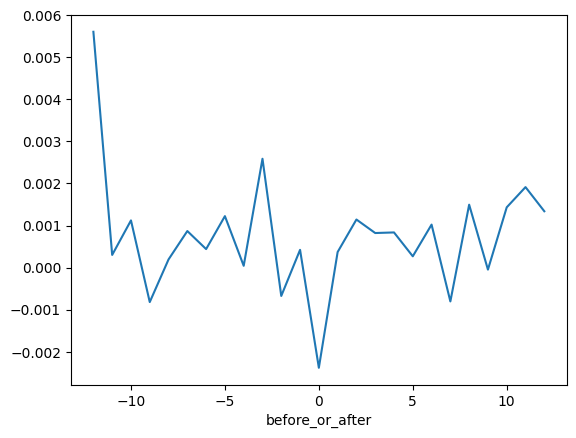

In [19]:
opex_stats['mean'].plot()

In [20]:
# Can I plot the above only from -9 to +9 days to reduce outliers that have fewer data points?

<Axes: xlabel='before_or_after'>

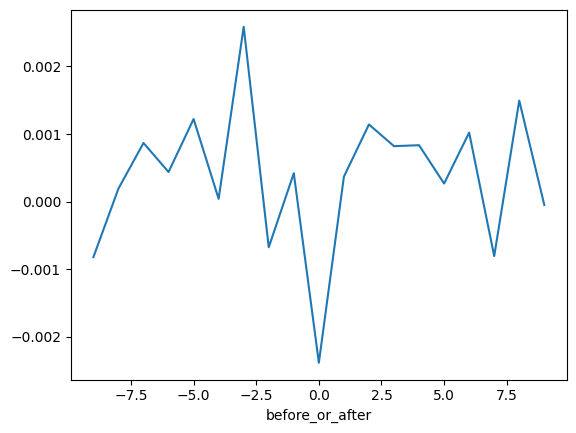

In [21]:
opex_stats.loc[-9:9, 'mean'].plot()

<Axes: xlabel='before_or_after'>

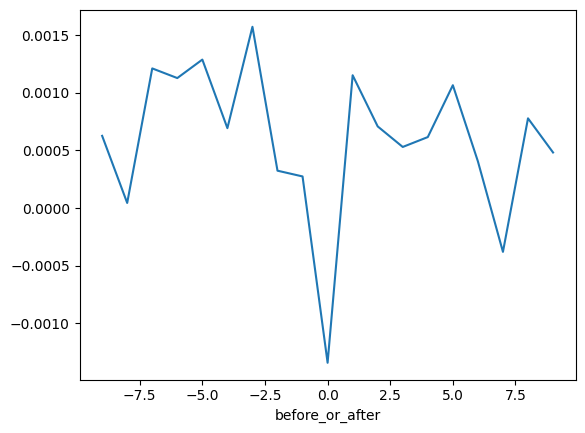

In [22]:
opex_stats.loc[-9:9, '50%'].plot()

## Month-specific analysis

In [23]:
# Get a subset of just quarter end months, excluding December (whose month end plays out differently because of Christmas)
#spy["mo"] = spy.index.month
#spy["qtr_end"] = 
qtr_end = spy[(spy.index.month == 3) | (spy.index.month == 6) | (spy.index.month == 9)]

In [24]:
qtr_end

,open,high,low,close,volume,split_ratio,dividend,capital_gains,log_return,day_of_week,opex_day,days_after_opex,days_before_opex,before_or_after,pop_avg_return,relative_return
date,,,,,,,,,,,,,,,,
2012-03-01 00:00:00-05:00,137.309998,137.990005,136.929993,137.729996,145023500,0.0,0.000,0.0,0.005168,3,False,8,11,8,0.00048,0.004688
2012-03-02 00:00:00-05:00,137.639999,137.820007,137.000000,137.309998,120638300,0.0,0.000,0.0,-0.003054,4,False,9,10,9,0.00048,-0.003535
2012-03-05 00:00:00-05:00,137.100006,137.199997,136.279999,136.750000,140765000,0.0,0.000,0.0,-0.004087,0,False,10,9,-9,0.00048,-0.004567
2012-03-06 00:00:00-05:00,135.350006,135.429993,134.360001,134.750000,202129900,0.0,0.000,0.0,-0.014733,1,False,11,8,-8,0.00048,-0.015214
2012-03-07 00:00:00-05:00,135.059998,135.910004,134.929993,135.690002,143692200,0.0,0.000,0.0,0.006952,2,False,12,7,-7,0.00048,0.006471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-16 00:00:00-04:00,561.739990,563.109985,559.900024,562.840027,36656100,0.0,0.000,0.0,0.001476,0,False,20,4,-4,0.00048,0.000995
2024-09-17 00:00:00-04:00,565.099976,566.580017,560.789978,563.070007,49321000,0.0,0.000,0.0,0.000409,1,False,21,3,-3,0.00048,-0.000072
2024-09-18 00:00:00-04:00,563.739990,568.690002,560.830017,561.400024,59044900,0.0,0.000,0.0,-0.002970,2,False,22,2,-2,0.00048,-0.003451


In [25]:
qtr_end_opex_stats = qtr_end['log_return'].groupby(qtr_end['before_or_after']).describe()

In [26]:
qtr_end_opex_stats

,count,mean,std,min,25%,50%,75%,max
before_or_after,,,,,,,,
-11,12.0,0.004161,0.008322,-0.008482,-0.002484,0.003874,0.009713,0.020093
-10,12.0,0.003471,0.010038,-0.016973,-0.000443,0.002330,0.006068,0.025307
-9,39.0,-0.002539,0.014924,-0.081313,-0.003313,-0.000243,0.003588,0.012015
-8,39.0,-0.000319,0.012384,-0.027703,-0.006780,-0.000235,0.003051,0.050451
-7,39.0,0.001389,0.011935,-0.049977,-0.002101,0.001631,0.005630,0.026458
-6,39.0,-0.003226,0.020560,-0.100569,-0.003682,0.001149,0.005964,0.015122
-5,39.0,0.001380,0.016227,-0.029424,-0.005939,0.001346,0.004058,0.082028
-4,39.0,-0.001659,0.020914,-0.115887,-0.002260,0.000608,0.007124,0.014397
-3,39.0,0.003924,0.013454,-0.044456,-0.001902,0.003764,0.007901,0.052585


<Axes: xlabel='before_or_after'>

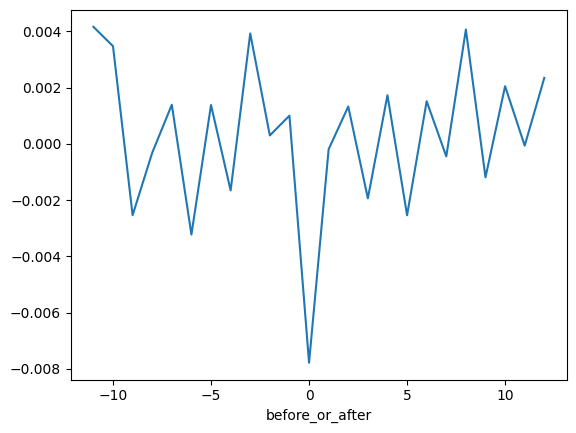

In [27]:
qtr_end_opex_stats['mean'].plot()

In [28]:
# What about June only?
jun = spy[(spy.index.month == 6)]

In [29]:
jun

,open,high,low,close,volume,split_ratio,dividend,capital_gains,log_return,day_of_week,opex_day,days_after_opex,days_before_opex,before_or_after,pop_avg_return,relative_return
date,,,,,,,,,,,,,,,,
2012-06-01 00:00:00-04:00,129.410004,131.500000,128.160004,128.160004,253240900,0.0,0.0,0.0,-0.025499,4,False,9,10,9,0.00048,-0.025980
2012-06-04 00:00:00-04:00,128.389999,128.740005,127.139999,128.100006,202545800,0.0,0.0,0.0,-0.000468,0,False,10,9,-9,0.00048,-0.000949
2012-06-05 00:00:00-04:00,127.849998,129.259995,127.779999,129.070007,164149400,0.0,0.0,0.0,0.007544,1,False,11,8,-8,0.00048,0.007063
2012-06-06 00:00:00-04:00,129.970001,132.029999,129.929993,131.970001,184202800,0.0,0.0,0.0,0.022220,2,False,12,7,-7,0.00048,0.021739
2012-06-07 00:00:00-04:00,133.470001,133.529999,131.779999,132.050003,184772700,0.0,0.0,0.0,0.000606,3,False,13,6,-6,0.00048,0.000126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24 00:00:00-04:00,544.330017,546.950012,542.619995,542.739990,45528700,0.0,0.0,0.0,-0.003256,0,False,1,18,1,0.00048,-0.003736
2024-06-25 00:00:00-04:00,543.989990,545.200012,542.440002,544.830017,38273300,0.0,0.0,0.0,0.003843,1,False,2,17,2,0.00048,0.003363
2024-06-26 00:00:00-04:00,543.690002,546.239990,543.030029,545.510010,38550600,0.0,0.0,0.0,0.001247,2,False,3,16,3,0.00048,0.000767


In [30]:
jun_opex_stats = jun['log_return'].groupby(jun['before_or_after']).describe()

In [31]:
jun_opex_stats

,count,mean,std,min,25%,50%,75%,max
before_or_after,,,,,,,,
-11,6.0,0.003783,0.007721,-0.008482,-0.000352,0.006491,0.008384,0.011815
-10,6.0,0.008490,0.009925,-0.001715,0.001179,0.007364,0.011970,0.025307
-9,13.0,0.001461,0.004482,-0.006169,-0.000971,0.000000,0.004578,0.012015
-8,13.0,0.000270,0.005309,-0.010369,-0.000242,0.000213,0.002175,0.009547
-7,13.0,0.001149,0.008931,-0.010932,-0.003483,-0.001493,0.003254,0.022220
-6,13.0,-0.003819,0.019036,-0.059377,-0.001366,0.000606,0.004638,0.015094
-5,13.0,-0.001867,0.010189,-0.029424,-0.006292,0.001651,0.002952,0.011905
-4,13.0,-0.002487,0.012565,-0.038708,-0.004295,0.000608,0.002236,0.009292
-3,13.0,0.005449,0.006216,-0.003018,0.001292,0.005437,0.007927,0.019065


<Axes: xlabel='before_or_after'>

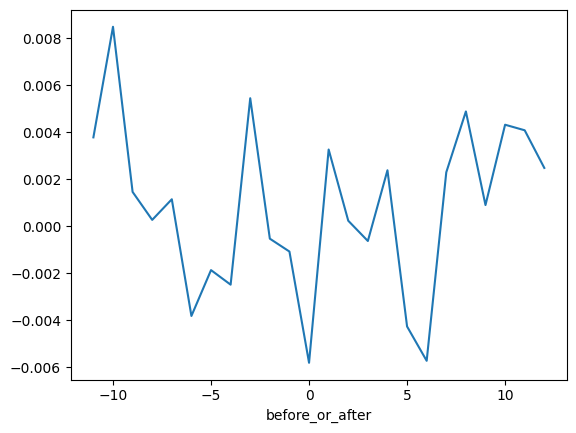

In [32]:
jun_opex_stats['mean'].plot()